In [ ]:
!pip install -U langgraph langsmith langchain_groq pydantic datasets faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
     

In [ ]:
import pandas as pd
from langchain_core.messages import SystemMessage
import os
from huggingface_hub import login
from google.colab import userdata
os.environ['GROQ_API_KEY']=userdata.get('groq_api_subash')

In [ ]:
from typing import Annotated,Optional

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from pydantic import BaseModel,ConfigDict,Field
from typing import Optional
from datasets import Dataset   # Define the search function
from sentence_transformers import SentenceTransformer
from datasets import load_dataset



In [ ]:
ST = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
class State(BaseModel):
    carry_on: Optional[bool]=False
    messages: Optional[str] = None
    topic: list
    brainstroming_topics: Optional[list] = []
    preferred_topics: Optional[list] = []
    stories : Optional[list]=[]
    final_story: Optional[str]=None
    retrievals : Optional[list]=[]
    model_config = ConfigDict(arbitrary_types_allowed=True)

graph_builder = StateGraph(State)

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,

)

In [ ]:

def retrieve(state: State) -> State:
  print('Moving to retrieval process')
  retrievals=[]
  for topic in state.topic:  # Loop through each topic
      embedded_query = ST.encode(topic)  # Embed each topic
      dataset = load_dataset("subashdvorak/tiktok-agentic-story",revision="embedded")
      data = dataset["train"].add_faiss_index("embeddings")
      scores, retrieved_examples = data.get_nearest_examples("embeddings", embedded_query, k=1)

      # Construct a list of dictionaries for this topic
      result = [{user: story} for user, story in zip(retrieved_examples['username'], retrieved_examples['agentic_story'])]
      retrievals.append(result)
      print('Retrieval process completed......')
  state.retrievals.append(retrievals)

  print('The retrieval is:\n',state.retrievals )
  # return State(messages="Retrieved",topic=state.topic,retrievals=state.retrievals)
  return state



In [ ]:
class StoryFormatter(BaseModel):
    """Always use this tool to structure your response to the user."""
    story: str=Field(description="How to introduce the scene and set the tone. What is happening in the scene? Describe key visuals and actions")
    narration:str=Field(description="Suggestions for narration or voiceover that complements the visuals." )
    text_in_the_Video:str=Field(description="Propose important text overlays for key moments.")
    transitions:str=Field(description="Smooth transitions between scenes to maintain flow.")
    emotional_tone:str=Field(description="The mood and energy of the scenes (e.g., excitement, calm, tension, joy")
    key_visuals:str=Field(description="Important props, locations, sound effects, or background music to enhance the video.")



def generate_story(state:State)-> State:
  topic=state.topic
  print('The state retrieval is:',state.retrievals)
  retrieval_list= state.retrievals[-1]
  agentic_stories = []

  for item in retrieval_list:
      print('item:', item[-1].values())

      agentic_stories.extend(item[-1].values())  # Add all stories to the list

  retrieval = " ".join(agentic_stories)

  if len(state.preferred_topics)==0:
    template = f'''I want to create a detailed storyline for a video in any domain. You have to provide me that storyline what to include in the video.
    Now, i am giving you the topic of the video. But the need is to generate the story focusing on the format that i'll provide to you.
    You can use this format for the reference purpose, not for the exact similar generation. Th format is:\n{retrieval}.
    \n\n Now let's start creating the storyline for my topic. The topic of the video is: \n\n{state.topic}'''
  else:
    template = f'''I want to create a detailed storyline for a video in the given topic. You have to provide me that storyline what to include in the video.
  Now, i am giving you the topic of the video. But the need is to generate the story focusing on the format that i'll provide to you.
  You can use this format for the reference purpose, not for the exact similar generation. The format is:\n{retrieval}.
  \n\n Now let's start creating the storyline for my topic. The topic of the video is: \n\n{state.topic}\n\n

  **Final Reminder** You have to strongly focus on these topics while creating the storyline: {state.preferred_topics[-1]}'''


  messages = [SystemMessage(content=template)]
  response = llm.bind_tools([StoryFormatter]).invoke(messages)
  print('The response is:',response)
  if hasattr(response, 'tool_calls') and response.tool_calls:
      response = response.tool_calls[0]['args']
  elif hasattr(response, 'content'):
      response = response.content
  else:
    response = "No response"
  state.stories.append(response)
  # return State(messages="Story generated", topic=state.topic,stories=state.stories)
  return state


In [ ]:
class BrainstromTopicFormatter(BaseModel):
  topic1:str=Field(description="First brainstorming topic of the story")
  topic2:str=Field(description="Second brainstorming topic of the story")
  topic3:str=Field(description="Third brainstorming topic of the story")
  topic4:str=Field(description="Fourth brainstorming topic of the story")

def generate_brainstroming(state:State)-> State:
  story=state.stories[-1]

  template= f'''I want to brainstorm ways to diversify or improve a storyline in exactly 4 sentences.
The goal is to generate creative and actionable ideas that are not on the storyline on how the storyline can be expanded or modified for better engagement.
For example: If the storyline is about creating a promotional video for a restaurant, the new suggestions might include:
- I want to showcase the chef preparing a signature dish.
- I want to add a sequence of customers sharing their experiences at the restaurant.
- I want to highlight the farm-to-table sourcing of ingredients with a short segment showing local farms.
- I want to include a time-lapse of the restaurant transforming from day to night, capturing its unique ambiance.
- I want to feature a quick interview with the owner sharing the story behind the restaurant.
Now, I will provide you with the storyline. The storyline is:\n{story}'''

  messages = [SystemMessage(content=template)]
  response = llm.bind_tools([BrainstromTopicFormatter]).invoke(messages)
  print('The response is:',response)
  if hasattr(response, 'tool_calls') and response.tool_calls:
      response = response.tool_calls[0]['args']
  elif hasattr(response, 'content'):
      response = response.content
  else:
    response = "No response"

  state.brainstroming_topics.append(response)
  print('The brainstroming topics are:',state.brainstroming_topics)
  # return State(messages="Story generated",topic=state.topic,brainstroming_topics=state.brainstroming_topics)
  return state





In [ ]:
def select_preferred_topics(state: State)-> State:
    print("---human_feedback---")

    topic_values = list(state.brainstroming_topics[-1].values())

    print("Available topics:")
    for idx, topic in enumerate(topic_values, 1):
        print(f"{idx}. {topic}")

    raw_input_str = input("Enter the numbers of your preferred topics (comma-separated), or press Enter to skip: ").strip()

    if not raw_input_str:
        state.carry_on=False
        print("No topics selected. Ending process.")
        return state

    try:
        preferred_indices = [int(i.strip()) for i in raw_input_str.split(",")]
        preferred_topics = [topic_values[i - 1] for i in preferred_indices if 0 < i <= len(topic_values)]
        state.preferred_topics.append(preferred_topics)
    except Exception:
        state.carry_on=False
        print("Invalid input. Please try again.")
        return state

    if not preferred_topics:
        state.carry_on=False
        print("No valid topics selected. Ending process.")
        return state

    print("You selected:")
    print(preferred_topics)
    state.carry_on=True
    return state


In [ ]:
def generate_final_story(state:State)-> State:
    template = f'''I want to create a detailed storyline for a video in the given topic. You have to provide me that storyline what to include in the video.
  Now, i am giving you the topic of the video. But the need is to generate the story focusing on the format that i'll provide to you.
  You can use this format for the reference purpose, not for the exact similar generation. The format is:\n{state.retrievals[-1]}.
  \n\n Now let's start creating the storyline for my topic. The topic of the video is: \n\n{state.topic}\n\n

  **Final Reminder** You have to strongly focus on these topics while creating the storyline: {[item for sublist in state.preferred_topics for item in sublist]}'''
    messages = [SystemMessage(content=template)]
    response = llm.bind_tools([StoryFormatter]).invoke(messages)
    print('The final response is:',response)
    if hasattr(response, 'tool_calls') and response.tool_calls:
        response = response.tool_calls[0]['args']
    elif hasattr(response, 'content'):
        response = response.content
    else:
      response = "No response"
    state.final_story=response
    state.stories.append(response)
    return state





In [ ]:
# def route_after_selection(output):
#     _, signal = output
#     return "retrieve" if signal == "CONTINUE" else END

def route_after_selection(state:State):
    print('The output is:',state.carry_on)
    return state.carry_on

In [ ]:
graph_builder.add_node(retrieve)
graph_builder.add_node(generate_story)
graph_builder.add_node(generate_brainstroming)
graph_builder.add_node(select_preferred_topics)
graph_builder.add_node(generate_final_story)


# Normal edges
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate_story")
graph_builder.add_edge("generate_story", "generate_brainstroming")
graph_builder.add_edge("generate_brainstroming", "select_preferred_topics")

# Conditional edge
graph_builder.add_conditional_edges("select_preferred_topics", route_after_selection,{True:'retrieve',False:'generate_final_story'})
graph_builder.add_edge("generate_final_story",END)

# Compile
graph = graph_builder.compile()

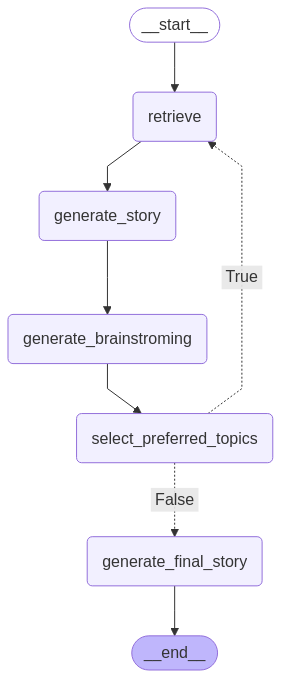

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
state = graph.invoke({"topic": ['I want to create a promotional video of restaurant.']})

Moving to retrieval process


  0%|          | 0/2 [00:00<?, ?it/s]

Retrieval process completed......
The retrieval is:
 [[[{'ishtukarkee': 'Certainly! Here\'s a breakdown of the video you sent, formatted according to your instructions:\n\n**1. Story:**\nThe video opens with a woman outdoors, using her phone. She\'s then seen on a phone call, expressing her desire to film a restaurant video. A friend is busy so she goes to restaurant with a different friend. The scene shifts to a restaurant setting, showcasing the staff and then a special dish. The video details the unique way to eat the dish, the ambiance and concludes with promotional details.\n\n**2. Characters:**\n\n*   **Woman with Phone:** She appears outdoors, wearing a long-sleeved black and white "Magic Moon" shirt and jeans, she speaks on the phone and initially seems disappointed that a friend is busy.\n*   **Woman with brown jacket:** This character wears a brown jacket with fur trim. She also makes calls on her phone.\n*    **The two female companions** They are both dressed in casual clot

  0%|          | 0/2 [00:00<?, ?it/s]

Retrieval process completed......
The retrieval is:
 [[[{'ishtukarkee': 'Certainly! Here\'s a breakdown of the video you sent, formatted according to your instructions:\n\n**1. Story:**\nThe video opens with a woman outdoors, using her phone. She\'s then seen on a phone call, expressing her desire to film a restaurant video. A friend is busy so she goes to restaurant with a different friend. The scene shifts to a restaurant setting, showcasing the staff and then a special dish. The video details the unique way to eat the dish, the ambiance and concludes with promotional details.\n\n**2. Characters:**\n\n*   **Woman with Phone:** She appears outdoors, wearing a long-sleeved black and white "Magic Moon" shirt and jeans, she speaks on the phone and initially seems disappointed that a friend is busy.\n*   **Woman with brown jacket:** This character wears a brown jacket with fur trim. She also makes calls on her phone.\n*    **The two female companions** They are both dressed in casual clot

In [ ]:
state['final_story']

{'emotional_tone': 'excitement',
 'key_visuals': 'chef preparing a signature dish, time-lapse of the restaurant transforming from day to night',
 'narration': 'A promotional video showcasing the unique ambiance and signature dishes of the restaurant.',
 'story': "The video opens with a shot of the chef preparing a signature dish, followed by a time-lapse of the restaurant transforming from day to night, capturing its unique ambiance. The video then transitions into showcasing the restaurant's interior, highlighting the staff and the ambiance. The video concludes with promotional details of the restaurant's events and dishes.",
 'text_in_the_Video': 'Propose important text overlays for key moments, such as the name of the restaurant, the name of the dish, and the dates of the events.',
 'transitions': 'Smooth transitions between scenes to maintain flow, using standard cuts and a mix of full body shots, close-ups, and scene pans.'}

In [ ]:
preferred_topics=state['preferred_topics']

In [ ]:
[item for sublist in preferred_topics for item in sublist]

['Showcase the chef preparing a signature dish in a behind-the-scenes segment',
 'Feature a quick interview with the owner sharing the story behind the restaurant and its unique features',
 "Highlight the restaurant's commitment to sustainability by featuring a segment on their eco-friendly practices, such as reducing food waste and using locally sourced ingredients.",
 'Include a time-lapse of the restaurant transforming from day to night, capturing its unique ambiance',
 'Showcase the chef preparing a signature dish in a behind-the-scenes segment',
 "Include a time-lapse of the restaurant's kitchen during a busy night, capturing the energy and chaos of a high-volume service."]

# Inferencing

In [ ]:
state_retrievals=[]

def retrieve(topic):
  retrievals=[]
  for topic in topic:  # Loop through each topic
      embedded_query = ST.encode(topic)  # Embed each topic
      dataset = load_dataset("subashdvorak/tiktok-agentic-story",revision="embedded")
      data = dataset["train"].add_faiss_index("embeddings")
      scores, retrieved_examples = data.get_nearest_examples("embeddings", embedded_query, k=1)

      # Construct a list of dictionaries for this topic
      result = [{user: story} for user, story in zip(retrieved_examples['username'], retrieved_examples['agentic_story'])]
      retrievals.append(result)
      print('Retrieval process completed......')

  state_retrievals.append(retrievals)
  # print('The retrieval is:\n',state_retrievals )
  return state_retrievals

state_retrievals=retrieve(['I want to make a promotional video of restaurant.','Hello'])
state_retrievals

  0%|          | 0/2 [00:00<?, ?it/s]

Retrieval process completed......


  0%|          | 0/2 [00:00<?, ?it/s]

Retrieval process completed......


[[[{'ishtukarkee': 'Certainly! Here\'s a breakdown of the video you sent, formatted according to your instructions:\n\n**1. Story:**\nThe video opens with a woman outdoors, using her phone. She\'s then seen on a phone call, expressing her desire to film a restaurant video. A friend is busy so she goes to restaurant with a different friend. The scene shifts to a restaurant setting, showcasing the staff and then a special dish. The video details the unique way to eat the dish, the ambiance and concludes with promotional details.\n\n**2. Characters:**\n\n*   **Woman with Phone:** She appears outdoors, wearing a long-sleeved black and white "Magic Moon" shirt and jeans, she speaks on the phone and initially seems disappointed that a friend is busy.\n*   **Woman with brown jacket:** This character wears a brown jacket with fur trim. She also makes calls on her phone.\n*    **The two female companions** They are both dressed in casual clothes. \n*   **Restaurant staff:** A waitress is seen i

In [ ]:
state_retrievals[-1]

[[{'ishtukarkee': 'Certainly! Here\'s a breakdown of the video you sent, formatted according to your instructions:\n\n**1. Story:**\nThe video opens with a woman outdoors, using her phone. She\'s then seen on a phone call, expressing her desire to film a restaurant video. A friend is busy so she goes to restaurant with a different friend. The scene shifts to a restaurant setting, showcasing the staff and then a special dish. The video details the unique way to eat the dish, the ambiance and concludes with promotional details.\n\n**2. Characters:**\n\n*   **Woman with Phone:** She appears outdoors, wearing a long-sleeved black and white "Magic Moon" shirt and jeans, she speaks on the phone and initially seems disappointed that a friend is busy.\n*   **Woman with brown jacket:** This character wears a brown jacket with fur trim. She also makes calls on her phone.\n*    **The two female companions** They are both dressed in casual clothes. \n*   **Restaurant staff:** A waitress is seen in

In [ ]:
class StoryFormatter(BaseModel):
    """Always use this tool to structure your response to the user."""
    story: str=Field(description="How to introduce the scene and set the tone. What is happening in the scene? Describe key visuals and actions")
    narration:str=Field(description="Suggestions for narration or voiceover that complements the visuals." )
    text_in_the_Video:str=Field(description="Propose important text overlays for key moments.")
    transitions:str=Field(description="Smooth transitions between scenes to maintain flow.")
    emotional_tone:str=Field(description="The mood and energy of the scenes (e.g., excitement, calm, tension, joy")
    key_visuals:str=Field(description="Important props, locations, sound effects, or background music to enhance the video.")



state_stories=[]
def generate_story(state_retrievals, preferred_topics):
  topic=['I want to make a promotional video of restaurant.']
  retrieval_list= state_retrievals[-1]
  agentic_stories = []

  for item in retrieval_list:
      print('item:', item[-1].values())

      agentic_stories.extend(item[-1].values())  # Add all stories to the list

  retrieval = " ".join(agentic_stories)
  print('Retrieval:',retrieval)

  if preferred_topics!=None:
      template = f'''I want to create a detailed storyline for a video in the given topic. You have to provide me that storyline what to include in the video.
  Now, i am giving you the topic of the video. But the need is to generate the story focusing on the format that i'll provide to you.
  You can use this format for the reference purpose, not for the exact similar generation. The format is:\n{retrieval}.
  \n\n Now let's start creating the storyline for my topic. The topic of the video is: \n\n{topic[-1]}\n\n

  **Final Reminder** You have to strongly focus on these topics while creating the storyline: {preferred_topics}'''

  else:
    template = f'''I want to create a detailed storyline for a video in the given topic. You have to provide me that storyline what to include in the video.
    Now, i am giving you the topic of the video. But the need is to generate the story focusing on the format that i'll provide to you.
    You can use this format for the reference purpose, not for the exact similar generation. The format is:\n{retrieval}.
    \n\n Now let's start creating the storyline for my topic. The topic of the video is: \n\n{topic[-1]}'''

  messages = [SystemMessage(content=template)]
  print('The message is:',messages)
  response = llm.bind_tools([StoryFormatter]).invoke(messages)
  print('The response of story generator is:\n',response)
  response= response.tool_calls[0]['args']
  state_stories.append(response)
  preferred_topics=None
  return response

# response= generate_story(state_retrievals)
# response
# #
# state_stories=generate_story(state_retrievals)
# state_stories

In [ ]:
class BrainstromTopicFormatter(BaseModel):
  topic1:str=Field(description="First brainstorming topic of the story")
  topic2:str=Field(description="Second brainstorming topic of the story")
  topic3:str=Field(description="Third brainstorming topic of the story")
  topic4:str=Field(description="Fourth brainstorming topic of the story")

def generate_brainstroming(story):
  brainstroming_topics=[]
  story=story[-1]

  template= f'''I want to brainstorm ways to diversify or improve a storyline in exactly 4 sentences.
The goal is to generate creative and actionable ideas that are not on the storyline on how the storyline can be expanded or modified for better engagement.
For example: If the storyline is about creating a promotional video for a restaurant, the new suggestions might include:
- I want to showcase the chef preparing a signature dish.
- I want to add a sequence of customers sharing their experiences at the restaurant.
- I want to highlight the farm-to-table sourcing of ingredients with a short segment showing local farms.
- I want to include a time-lapse of the restaurant transforming from day to night, capturing its unique ambiance.
- I want to feature a quick interview with the owner sharing the story behind the restaurant.
Now, I will provide you with the storyline. The storyline is:\n{story}'''

  messages = [SystemMessage(content=template)]
  response = llm.bind_tools([BrainstromTopicFormatter]).invoke(messages)
  response= response.tool_calls[0]['args']
  brainstroming_topics.append(response)
  return brainstroming_topics

brainstorming_topics=generate_brainstroming(state_stories)
brainstorming_topics

[{'topic1': "Showcase a behind-the-scenes look at the restaurant's kitchen, highlighting the chefs' skills and the preparation of the special dish.",
  'topic2': "Create a 'day in the life' segment featuring a staff member, showcasing their daily tasks and interactions with customers.",
  'topic3': 'Develop a social media integration, where customers can share their own experiences and photos at the restaurant, and the restaurant can respond and engage with them.',
  'topic4': "Include a 'sneak peek' segment, where the restaurant reveals a new dish or promotion, building anticipation and excitement among viewers."}]

In [ ]:
preferred_topics=[
    brainstorming_topics[-1]['topic1'],
    brainstorming_topics[-1]['topic3']

]
preferred_topics

NameError: name 'brainstorming_topics' is not defined

In [ ]:
retrievals=retrieve(preferred_topics)

  0%|          | 0/2 [00:00<?, ?it/s]

Retrieval process completed......


  0%|          | 0/2 [00:00<?, ?it/s]

Retrieval process completed......


In [ ]:
generate_story(retrievals,preferred_topics)

item: dict_values(['Okay, here\'s a breakdown of the video\'s storyline, characters, and other elements:\n\n**1. Story:** The video opens inside a restaurant, showcasing unique table setups with individual grilling stations and overhead exhaust pipes. A staff member is seen preparing at a station. The scene shifts to show the restaurant\'s exterior with a graphic that states "K5" and then focuses on a grill top at a table. The video then introduces a staff member carrying a silver exhaust pipe, which is then installed. Subsequently, a staff member is seen opening a refrigerator and picks two bottles of beer. The beers are brought to the table where two men are waiting. The beers are opened, poured, and then the camera focuses on the grill and then another staff member is seen carrying a pan with meat.  Hot coals are added to the grill. The next scene shows the placing of marinated meats, and other platters of sides on the table and those are grilled. The diners eat the grilled foods us

IndexError: list index out of range

In [ ]:
brainstroming_topics = [{'topic1': "Showcase a behind-the-scenes look at the restaurant's kitchen, highlighting the chefs' skills and the preparation of the special dish.",
  'topic2': "Create a 'day in the life' segment featuring a staff member, showcasing their daily tasks and interactions with customers.",
  'topic3': 'Develop a social media integration, where customers can share their own experiences and photos at the restaurant, and the restaurant can respond and engage with them.',
  'topic4': "Include a 'sneak peek' segment, where the restaurant reveals a new dish or promotion, building anticipation and excitement among viewers."}]

In [ ]:
from langgraph.types import interrupt
def human_feedback(state=None):
    print("---human_feedback---")

    # Use your provided brainstorming_topics list
    brainstorming_topics = [{
        'topic1': "Showcase a behind-the-scenes look at the restaurant's kitchen, highlighting the chefs' skills and the preparation of the special dish.",
        'topic2': "Create a 'day in the life' segment featuring a staff member, showcasing their daily tasks and interactions with customers.",
        'topic3': 'Develop a social media integration, where customers can share their own experiences and photos at the restaurant, and the restaurant can respond and engage with them.',
        'topic4': "Include a 'sneak peek' segment, where the restaurant reveals a new dish or promotion, building anticipation and excitement among viewers."
    }]

    # Flatten and list the topic strings
    topic_dict = brainstorming_topics[0]
    topic_keys = list(topic_dict.keys())
    topic_values = list(topic_dict.values())

    print("Available topics:")
    for idx, topic in enumerate(topic_values, 1):
        print(f"{idx}. {topic}")

    # Ask for selection
    raw_input = input("Enter the numbers of your preferred topics (comma-separated): ")

    # Parse and validate
    try:
        preferred_indices = [int(i.strip()) for i in raw_input.split(",")]
        preferred_topics = [topic_values[i - 1] for i in preferred_indices if 0 < i <= len(topic_values)]
    except Exception:
        print("Invalid input. Please try again.")
        return human_feedback(state)

    print("You selected:")
    print(preferred_topics)


    return preferred_topics


In [ ]:
human_feedback()

---human_feedback---
Available topics:
1. Showcase a behind-the-scenes look at the restaurant's kitchen, highlighting the chefs' skills and the preparation of the special dish.
2. Create a 'day in the life' segment featuring a staff member, showcasing their daily tasks and interactions with customers.
3. Develop a social media integration, where customers can share their own experiences and photos at the restaurant, and the restaurant can respond and engage with them.
4. Include a 'sneak peek' segment, where the restaurant reveals a new dish or promotion, building anticipation and excitement among viewers.
Enter the numbers of your preferred topics (comma-separated): 1,4
You selected:
["Showcase a behind-the-scenes look at the restaurant's kitchen, highlighting the chefs' skills and the preparation of the special dish.", "Include a 'sneak peek' segment, where the restaurant reveals a new dish or promotion, building anticipation and excitement among viewers."]


["Showcase a behind-the-scenes look at the restaurant's kitchen, highlighting the chefs' skills and the preparation of the special dish.",
 "Include a 'sneak peek' segment, where the restaurant reveals a new dish or promotion, building anticipation and excitement among viewers."]

In [ ]:
def human_feedback(state=None):
    print("---human_feedback---")

    brainstorming_topics = [{
        'topic1': "Showcase a behind-the-scenes look at the restaurant's kitchen, highlighting the chefs' skills and the preparation of the special dish.",
        'topic2': "Create a 'day in the life' segment featuring a staff member, showcasing their daily tasks and interactions with customers.",
        'topic3': 'Develop a social media integration, where customers can share their own experiences and photos at the restaurant, and the restaurant can respond and engage with them.',
        'topic4': "Include a 'sneak peek' segment, where the restaurant reveals a new dish or promotion, building anticipation and excitement among viewers."
    }]

    topic_dict = brainstorming_topics[0]
    topic_values = list(topic_dict.values())

    print("Available topics:")
    for idx, topic in enumerate(topic_values, 1):
        print(f"{idx}. {topic}")

    # Ask for selection
    raw_input_str = input("Enter the numbers of your preferred topics (comma-separated), or press Enter to skip: ").strip()

    # If user pressed Enter with no input, end early
    if not raw_input_str:
        print("No topics selected. Ending process.")
        return None

    try:
        preferred_indices = [int(i.strip()) for i in raw_input_str.split(",")]
        preferred_topics = [topic_values[i - 1] for i in preferred_indices if 0 < i <= len(topic_values)]
    except Exception:
        print("Invalid input. Please try again.")
        return human_feedback(state)

    if not preferred_topics:
        print("No valid topics selected. Ending process.")
        return None


    return preferred_topics


In [ ]:
human_feedback()


---human_feedback---
Available topics:
1. Showcase a behind-the-scenes look at the restaurant's kitchen, highlighting the chefs' skills and the preparation of the special dish.
2. Create a 'day in the life' segment featuring a staff member, showcasing their daily tasks and interactions with customers.
3. Develop a social media integration, where customers can share their own experiences and photos at the restaurant, and the restaurant can respond and engage with them.
4. Include a 'sneak peek' segment, where the restaurant reveals a new dish or promotion, building anticipation and excitement among viewers.
Enter the numbers of your preferred topics (comma-separated), or press Enter to skip: 
No topics selected. Ending process.
